# Hybrid DMRG-like training of MPS

Here we show a way of training MPS models in a DMRG fashion, but where all MPS
cores are optimized at the same time, thus making the training process much faster.
In this approach, MPS cores are merged in pairs, contracting each node with a
neighbour, and the whole model is trained like that. After a few iterations,
the cores are unmerged and merged again with the other neighbour. This process
can be repeated as many times as desired.

This has the advantage that bond dimensions can be learned during the training
process, and also the optimization is much faster than traditional DMRG, since
all cores are updated at once.

In [ ]:
%mkdir data
%mkdir models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

import tensorkrowch as tk

In [2]:
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

## Dataset

In [3]:
# MNIST Dataset
dataset_name = 'mnist'
batch_size = 64
image_size = 28
input_size = image_size ** 2
num_classes = 10

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(image_size, antialias=True),
                               ])

# Load data
train_dataset = datasets.MNIST(root='data/',
                               train=True,
                               transform=transform,
                               download=True)
test_dataset = datasets.MNIST(root='data/',
                              train=False,
                              transform=transform,
                              download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

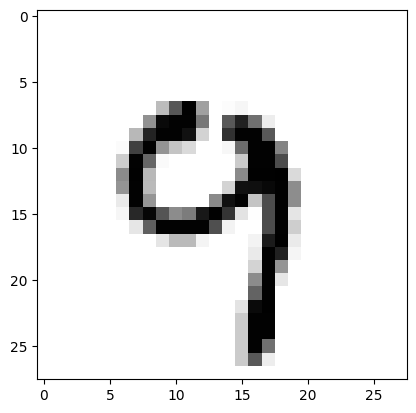

9


In [4]:
random_sample = torch.randint(low=0, high=len(train_dataset), size=(1,)).item()

plt.imshow(train_dataset[random_sample][0].squeeze(0), cmap='Greys')
plt.show()

print(train_dataset[random_sample][1])

## Define model

In [5]:
class MPS_HDMRG(tk.models.MPSLayer):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.out_node.get_axis('input').name = 'output'
        
        self.block_length = None
        self.even = None
    
    def merge(self, even, block_length):
        n_blocks = self.n_features // block_length
        
        if even:
            # Leave reamining nodes at the end
            mats_env = self.mats_env[:(n_blocks * block_length)]
        else:
            # Leave remaining nodes at the beggining
            mats_env = self.mats_env[(-n_blocks * block_length):]
        
        blocks = []
        for i in range(n_blocks):
            block_nodes = mats_env[(i * block_length):((i + 1) * block_length)]
        
            block = block_nodes[0]
            for node in block_nodes[1:]:
                block = tk.contract_between_(block, node)
            block = block.parameterize(True)
            block.name = f'block_({i})'
            
            blocks.append(block)
        
        if even:
            self._mats_env = blocks + self.mats_env[(n_blocks * block_length):]
        else:
            self._mats_env = self.mats_env[:(-n_blocks * block_length)] + blocks
        
        self.block_length = block_length
        self.even = even
        
    def unmerge(self, side='left', rank=None, cum_percentage=None):
        n_blocks = self.n_features // self.block_length
        
        if self.even:
            # Leave reamining nodes at the end
            blocks = self.mats_env[:n_blocks]
        else:
            # Leave remaining nodes at the beggining
            blocks = self.mats_env[-n_blocks:]
        
        mats_env = []
        for i in range(n_blocks):
            block = blocks[i]
            block_nodes = []
            for j in range(self.block_length - 1):
                node1_axes = block.axes[:2]
                node2_axes = block.axes[2:]
                    
                node, block = tk.split_(block,
                                        node1_axes,
                                        node2_axes,
                                        side=side,
                                        rank=rank,
                                        cum_percentage=cum_percentage)
                block.get_axis('split').name = 'left'
                node.get_axis('split').name = 'right'
                node.name = f'mats_env_({i * self.block_length + j})'
                node = node.parameterize(True)
                
                block_nodes.append(node)
                
            block.name = f'mats_env_({i * self.block_length + j + 1})'
            block = block.parameterize(True)
            block_nodes.append(block)

            mats_env += block_nodes
        
        if self.even:
            self._mats_env = mats_env + self.mats_env[n_blocks:]
        else:
            self._mats_env = self.mats_env[:-n_blocks ] + mats_env
        
        self.block_length = None
        self.even = None
    
    def contract(self):
        result_mats = []
        for node in self.mats_env:
            while any(['input' in name for name in node.axes_names]):
                for axis in node.axes:
                    if 'input' in axis.name:
                        data_node = node.neighbours(axis)
                        node = node @ data_node
                        break
            result_mats.append(node)
        
        result_mats = [self.left_node] + result_mats + [self.right_node]
        
        result = result_mats[0]
        for node in result_mats[1:]:
            result @= node
        
        return result

In [6]:
# Model hyperparameters
embedding_dim = 3
output_dim = num_classes
bond_dim = 10
init_method = 'randn_eye'
block_length = 2
cum_percentage = 0.98

In [7]:
# Initialize network
model_name = 'mps_dmrg_hybrid'
mps = MPS_HDMRG(n_features=input_size + 1,
                in_dim=embedding_dim,
                out_dim=num_classes,
                bond_dim=bond_dim,
                boundary='obc',
                init_method=init_method,
                std=1e-6,
                device=device)

# Important to set data nodes before merging nodes
mps.set_data_nodes()

In [8]:
def embedding(x):
    x = tk.embeddings.poly(x, degree=embedding_dim - 1)
    return x

## Train

In [9]:
# Hyperparameters
learning_rate = 1e-4
weight_decay = 1e-8
num_epochs = 10
move_block_epochs = 100

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

In [10]:
# Check accuracy on training & test to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            x = x.reshape(x.shape[0], -1)
            
            scores = model(embedding(x))
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        accuracy = float(num_correct) / float(num_samples) * 100
    model.train()
    return accuracy

In [11]:
# Train network
even = True
mps.merge(even, block_length)
mps.trace(torch.zeros(1, input_size, embedding_dim, device=device))
optimizer = optim.Adam(mps.parameters(),
                       lr=learning_rate,
                       weight_decay=weight_decay)

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)
        
        # Get to correct shape
        data = data.reshape(data.shape[0], -1)
        
        # Forward
        scores = mps(embedding(data))
        loss = criterion(scores, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient descent
        optimizer.step()
        
        if (batch_idx + 1) % move_block_epochs == 0:
            if even:
                mps.unmerge(side='left',
                            rank=bond_dim,
                            cum_percentage=cum_percentage)
            else:
                mps.unmerge(side='right',
                            rank=bond_dim,
                            cum_percentage=cum_percentage)
            
            even = not even
            mps.merge(even, block_length)
            mps.trace(torch.zeros(1, input_size, embedding_dim, device=device))
            optimizer = optim.Adam(mps.parameters(),
                                   lr=learning_rate,
                                   weight_decay=weight_decay)
    
    train_acc = check_accuracy(train_loader, mps)
    test_acc = check_accuracy(test_loader, mps)
    
    print(f'* Epoch {epoch + 1:<3} ({even=}) => Train. Acc.: {train_acc:.2f},'
          f' Test Acc.: {test_acc:.2f}')

# Reset before saving the model
mps.reset()
torch.save(mps.state_dict(), f'models/{model_name}_{dataset_name}.pt')

* Epoch 1   (even=False) => Train. Acc.: 95.27, Test Acc.: 95.25
* Epoch 2   (even=True) => Train. Acc.: 96.49, Test Acc.: 96.24
* Epoch 3   (even=False) => Train. Acc.: 97.59, Test Acc.: 96.84
* Epoch 4   (even=True) => Train. Acc.: 97.81, Test Acc.: 97.15
* Epoch 5   (even=False) => Train. Acc.: 98.38, Test Acc.: 97.52
* Epoch 6   (even=True) => Train. Acc.: 98.29, Test Acc.: 97.65
* Epoch 7   (even=False) => Train. Acc.: 98.38, Test Acc.: 97.70
* Epoch 8   (even=True) => Train. Acc.: 98.45, Test Acc.: 97.62
* Epoch 9   (even=False) => Train. Acc.: 98.42, Test Acc.: 97.69
* Epoch 10  (even=True) => Train. Acc.: 98.37, Test Acc.: 97.24


In [14]:
mps.unmerge(rank=bond_dim, cum_percentage=cum_percentage)

In [15]:
mps.update_bond_dim()

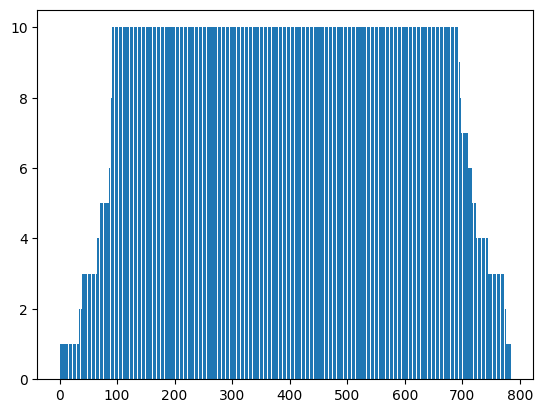

In [16]:
plt.bar(torch.arange(mps.n_features - 1) + 1, torch.tensor(mps.bond_dim))
plt.show()